In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [33]:
latent_dim = 100
image_size = 512
channels = 3  # Assuming RGB images
epochs = 20  # You might need to adjust this for WGAN-GP
batch_size = 64  # Experiment with different batch sizes
learning_rate = 0.0002  # Experiment with different learning rates
gradient_penalty_weight = 10  # Weight for gradient penalty

In [34]:
# Check if MPS is available (Metal GPU support for macOS)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [35]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 16 * 16), # Adjusted to output shape suitable for upsampling
            nn.BatchNorm1d(256 * 16 * 16),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 16, 16)), # Start with a feature map of 256 channels and size 16x16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # Output: 32 x 128 x 128
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, channels, 4, stride=2, padding=1), # Output: 3 x 256 x 256
            nn.Tanh(),
            nn.ConvTranspose2d(channels, channels, 4, stride=2, padding=1) # Final layer to get to 512 x 512)
    def forward(self, z):
        return self.model(z)

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 16, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 16) * (image_size // 16), 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [ ]:
# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate * 0.5, betas=(0.5, 0.999)) # Reduced learning rate for D

In [42]:
def gradient_penalty(real_images, fake_images, discriminator):
    """Calculates the gradient penalty for WGAN-GP."""

    # Randomly interpolate between real and fake images
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device).expand_as(real_images)
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images

    # Calculate the gradients of the discriminator w.r.t. the interpolated images
    interpolated_images.requires_grad_()
    interpolated_scores = discriminator(interpolated_images)
    interpolated_gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True,
    )[0].view(real_images.size(0), -1)

    # Calculate the gradient penalty
    gradient_penalty = ((interpolated_gradients.norm(2, 1) - 1) ** 2).mean()
    return gradient_penalty

In [43]:
from torchvision.datasets import ImageFolder

In [44]:
# Function to generate noise
def generate_noise(batch_size, latent_dim, device):
    return torch.randn(batch_size, latent_dim, device=device)

# Data
dataset_path = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_preprocessed_Lung/train' 
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [45]:
# Function to save and display generated samples
def save_and_show_generated_images(epoch, samples, path="./generated_images/"):
    if not os.path.exists(path):
        os.makedirs(path)
    grid = torchvision.utils.make_grid(samples, nrow=6, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.show()  # Display generated images
    plt.savefig(f"{path}/gan_image_epoch_{epoch}.png")
    plt.close()

def display_generated_images(batch_images, nrow=6):
    """Display generated images in a grid format."""
    grid = torchvision.utils.make_grid(batch_images, nrow=nrow, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()  # Display generated images

In [46]:
# Function to save the model, optimizer, and other states
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, checkpoint_path="checkpoint.pth"):
    state = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'avg_d_loss': avg_d_loss,
        'avg_g_loss': avg_g_loss
    }
    torch.save(state, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")

In [47]:
# Function to load the checkpoint to resume training
def load_checkpoint(checkpoint_path, generator, discriminator, optimizer_G, optimizer_D):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming training from epoch {start_epoch}")
        return start_epoch
    else:
        print("No checkpoint found, starting from scratch.")
        return 0

/var/folders/46/w07b6hp90zqbzpczfxw8fxd40000gn/T/ipykernel_83238/4233596385.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 15
[Epoch 15/20] [D loss: 2.0301] [G loss: 2.6506] [Real Accuracy: 89.97%] [Fake Accuracy: 87.52%]


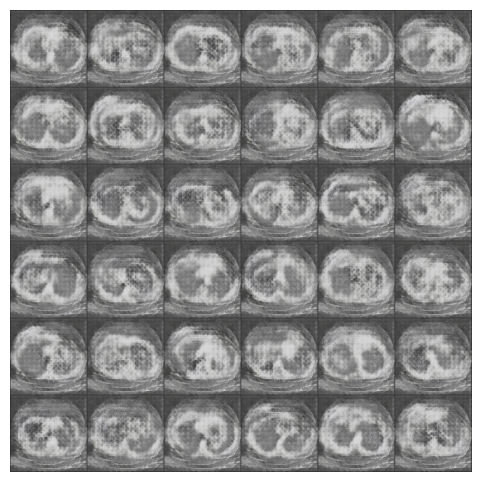

Checkpoint saved at epoch 15
[Epoch 16/20] [D loss: 2.8362] [G loss: 3.8932] [Real Accuracy: 87.61%] [Fake Accuracy: 90.15%]


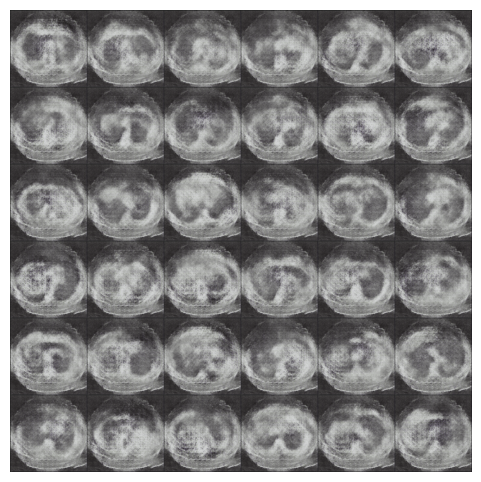

Checkpoint saved at epoch 16
[Epoch 17/20] [D loss: 2.2453] [G loss: 3.1325] [Real Accuracy: 89.34%] [Fake Accuracy: 87.76%]


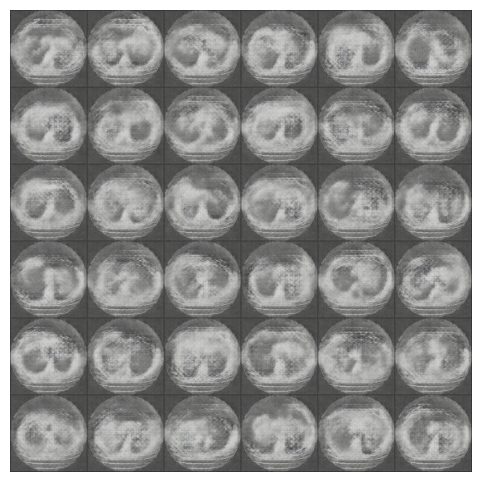

Checkpoint saved at epoch 17
[Epoch 18/20] [D loss: 2.1200] [G loss: 2.9229] [Real Accuracy: 89.22%] [Fake Accuracy: 89.00%]


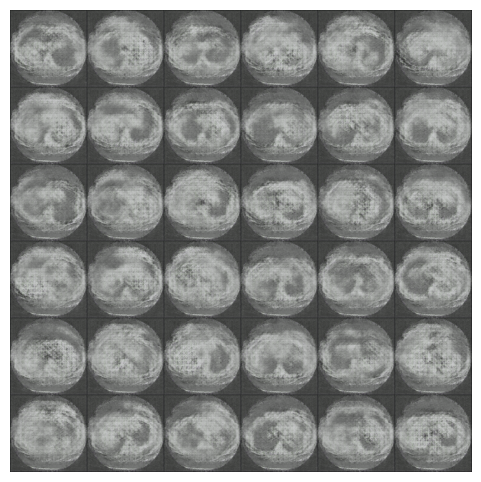

Checkpoint saved at epoch 18
[Epoch 19/20] [D loss: 2.1976] [G loss: 3.0831] [Real Accuracy: 89.43%] [Fake Accuracy: 89.58%]


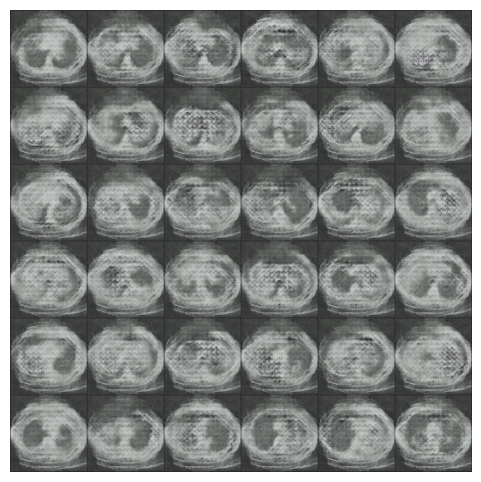

Checkpoint saved at epoch 19
Training completed.


In [27]:
# Training the GAN
start_epoch = load_checkpoint("checkpoint.pth", generator, discriminator, optimizer_G, optimizer_D)

for epoch in range(start_epoch, epochs):
    total_d_loss = 0
    total_g_loss = 0
    real_accuracy = 0
    fake_accuracy = 0
    num_batches = len(dataloader)

    for i, (real_images, _) in enumerate(dataloader):

        # Set batch size to match real images
        batch_size = real_images.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Training Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_images = real_images.to(device)
        real_loss = adversarial_loss(discriminator(real_images), valid)

        # Fake images
        z = generate_noise(batch_size, latent_dim, device)
        fake_images = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_images), fake)

        # Gradient Penalty
        gradient_penalty_value = gradient_penalty(real_images, fake_images, discriminator)
        
        # Discriminator loss
        d_loss = real_loss + fake_loss + gradient_penalty_weight * gradient_penalty_value
        d_loss.backward()
        optimizer_D.step()

        # Training Generator
        optimizer_G.zero_grad()

        # Generate Fake Images
        z = generate_noise(batch_size, latent_dim, device)
        generated_images = generator(z)

        # Generator loss
        g_loss = adversarial_loss(discriminator(generated_images), valid)
        g_loss.backward()
        optimizer_G.step()

        # Accuracy calculations
        real_accuracy += (discriminator(real_images).round() == valid).float().mean().item()
        fake_accuracy += (discriminator(generated_images.detach()).round() == fake).float().mean().item()

        # Accumulate losses
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    # Average losses and accuracy for the epoch
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    avg_real_accuracy = real_accuracy / num_batches * 100
    avg_fake_accuracy = fake_accuracy / num_batches * 100

    # Log the progress for each epoch
    print(f"[Epoch {epoch}/{epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}] "
          f"[Real Accuracy: {avg_real_accuracy:.2f}%] [Fake Accuracy: {avg_fake_accuracy:.2f}%]")
    
    # Display generated images for the current batch
    display_generated_images(generated_images[:36]) # Display first 36 images

    # Save the model after every epoch
    save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, 
                    avg_d_loss, avg_g_loss)
    
print("Training completed.")


In [264]:
# Load the checkpoint
checkpoint = torch.load("checkpoint.pth")
discriminator_state_dict = checkpoint['discriminator_state_dict']

# Filter out incompatible keys based on shape
model_state_dict = discriminator.state_dict()
filtered_state_dict = {k: v for k, v in discriminator_state_dict.items() if k in model_state_dict and v.size() == model_state_dict[k].size()}

# Load the filtered state dict
discriminator.load_state_dict(filtered_state_dict, strict=False)


/var/folders/46/w07b6hp90zqbzpczfxw8fxd40000gn/T/ipykernel_83238/1974943022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth")


<All keys matched successfully>

In [265]:
# Training the GAN
start_epoch = load_checkpoint("checkpoint.pth", generator, discriminator, optimizer_G, optimizer_D)

for epoch in range(start_epoch, epochs):
    total_d_loss = 0
    total_g_loss = 0
    real_accuracy = 0
    fake_accuracy = 0
    num_batches = len(dataloader)

    for i, (real_images, _) in enumerate(dataloader):
        
        # Set batch size to match real images
        batch_size = real_images.size(0)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Training Discriminator
        optimizer_D.zero_grad()
        
        # Real images
        real_images = real_images.to(device)
        real_loss = adversarial_loss(discriminator(real_images), valid)
        
        # Fake images
        z = generate_noise(batch_size, latent_dim, device)
        fake_images = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_images), fake)

        # Gradient Penalty
        gradient_penalty_value = gradient_penalty(real_images, fake_images, discriminator)

        # Discriminator loss
        d_loss = real_loss + fake_loss + gradient_penalty_weight * gradient_penalty_value
        d_loss.backward()
        optimizer_D.step()

        # Training Generator
        optimizer_G.zero_grad()
        
        # Generate Fake Images
        z = generate_noise(batch_size, latent_dim, device)
        generated_images = generator(z)
        
        # Generator loss
        g_loss = adversarial_loss(discriminator(generated_images), valid)
        g_loss.backward()
        optimizer_G.step()

        # Accuracy calculations
        real_accuracy += (discriminator(real_images).round() == valid).float().mean().item()
        fake_accuracy += (discriminator(generated_images.detach()).round() == fake).float().mean().item()

        # Accumulate losses
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
    
    # Average losses and accuracy for the epoch
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    avg_real_accuracy = real_accuracy / num_batches * 100
    avg_fake_accuracy = fake_accuracy / num_batches * 100
    
    # Log the progress for each epoch
    print(f"[Epoch {epoch+1}/{epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}] "
          f"[Real Accuracy: {avg_real_accuracy:.2f}%] [Fake Accuracy: {avg_fake_accuracy:.2f}%]")
    
    # Display generated images for the current batch
    display_generated_images(generated_images[:36])  # Display first 36 images
    
    # Save the model after every epoch
    save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss)

print("Training completed.")

/var/folders/46/w07b6hp90zqbzpczfxw8fxd40000gn/T/ipykernel_83238/4233596385.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 20
Training completed.


In [266]:
print(f"Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

Discriminator Loss: 2.277780294418335, Generator Loss: 7.367157459259033


In [267]:
# Save the model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

# Load the model
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

/var/folders/46/w07b6hp90zqbzpczfxw8fxd40000gn/T/ipykernel_83238/534981140.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generato

<All keys matched successfully>

In [268]:
def display_generated_images1(batch_images, nrow=2):
    """Display generated images in a grid format."""
    grid = torchvision.utils.make_grid(batch_images, nrow=nrow, normalize=True)
    plt.figure(figsize=(7, 7))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()  # Display generated images

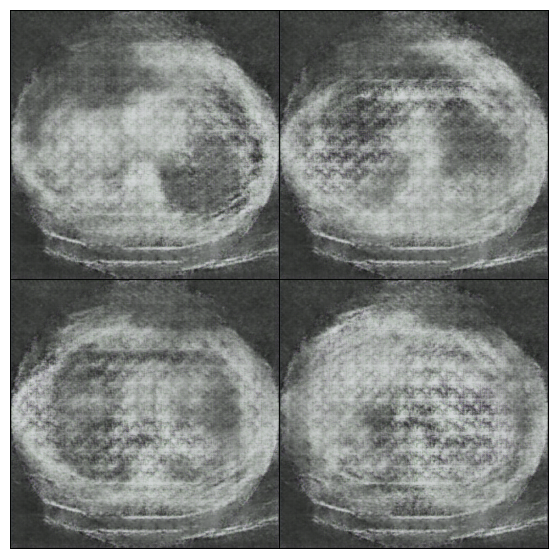

In [269]:
# Generate noise and move it to the selected device
z = generate_noise(4, latent_dim, device=device)  # Ensure consistency with latent_dim
generated_images = generator(z)  # Now should work without missing arguments
display_generated_images1(generated_images)


In [270]:
def get_features(images, model, device):
    # Preprocess the images and move them to the device (GPU/CPU)
    processed_images = torch.stack([preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        features = model(processed_images)
    # Pooling the output features to make them comparable
    features = adaptive_avg_pool2d(features, output_size=(1, 1))
    return features.cpu().numpy().reshape(len(images), -1)


In [271]:
def calculate_fid(real_images, generated_images, model, device):
    # Get features for real and generated images
    real_features = get_features(real_images, model, device)
    generated_features = get_features(generated_images, model, device)
    
    # Calculate mean and covariance for real and generated images
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
    
    # Compute squared difference between means
    diff = mu_real - mu_generated
    
    # Compute product of covariances
    covmean, _ = sqrtm(sigma_real @ sigma_generated, disp=False)
    
    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate the FID score
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    return fid_score


In [272]:
real_outputs = discriminator(real_images)
fake_outputs = discriminator(generated_images)


In [273]:
# Define latent_dim
latent_dim = 100  # Example, change this as needed

# Latent vector size needs to match the expected input size of the first Linear layer
# Make sure z has the shape (batch_size, latent_dim)
z = torch.randn(batch_size, latent_dim).to(device)

# Pass through the generator
generated_images = generator(z)


In [276]:
# Define the loss function (Binary Cross-Entropy Loss)
criterion = nn.BCEWithLogitsLoss()


Epoch [1/20], D Loss: 1.0234425666010503, G Loss: 0.6922050741304576
Epoch [2/20], D Loss: 1.0307445398251491, G Loss: 0.6815482107825758
Epoch [3/20], D Loss: 1.024120907057528, G Loss: 0.6850949925947354
Epoch [4/20], D Loss: 1.012876973432653, G Loss: 0.690506480144382
Epoch [5/20], D Loss: 1.010197643590221, G Loss: 0.6917527757301463
Epoch [6/20], D Loss: 1.0091672026162328, G Loss: 0.6922631154423354
Epoch [7/20], D Loss: 1.0085606855504654, G Loss: 0.6925488877461443
Epoch [8/20], D Loss: 1.0082170191933126, G Loss: 0.6926891387127675
Epoch [9/20], D Loss: 1.0079340567638304, G Loss: 0.6927853983578798
Epoch [10/20], D Loss: 1.007884190156798, G Loss: 0.6928335471549248
Epoch [11/20], D Loss: 1.0078652404171373, G Loss: 0.6928256649047033
Epoch [12/20], D Loss: 1.007742989022014, G Loss: 0.6928643926617184
Epoch [13/20], D Loss: 1.0075985675864567, G Loss: 0.692949152322789
Epoch [14/20], D Loss: 1.0076135211337396, G Loss: 0.692939174010267
Epoch [15/20], D Loss: 1.007489438287

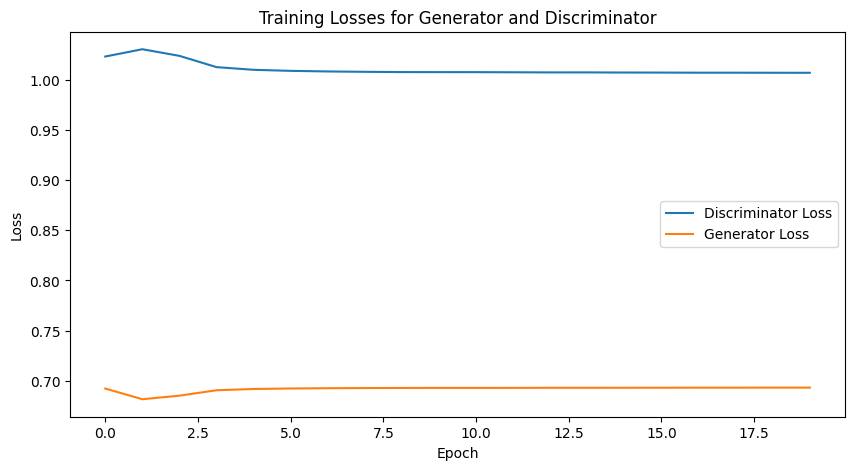

In [277]:
import matplotlib.pyplot as plt

# Initialize lists to store the losses
d_losses = []  # List to store discriminator losses
g_losses = []  # List to store generator losses

# Training loop
num_epochs = 20  # Define the number of epochs
for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)

        # Calculate loss for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())

        d_real_loss = criterion(real_output, real_labels)
        d_fake_loss = criterion(fake_output, fake_labels)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()

        # Calculate generator loss
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)  # Want the generator to fool the discriminator

        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses for plotting
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    # Store the average losses for this epoch
    d_losses.append(epoch_d_loss / len(dataloader))
    g_losses.append(epoch_g_loss / len(dataloader))

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_losses[-1]}, G Loss: {g_losses[-1]}")

# Step 4: Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), d_losses, label='Discriminator Loss')
plt.plot(range(num_epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for Generator and Discriminator')
plt.legend()
plt.show()
